    Args:
        patch_size (List[int]): Patch size.
        embed_dim (int): Patch embedding dimension.
        depths (List(int)): Depth of each Swin Transformer layer.
        num_heads (List(int)): Number of attention heads in different layers.
        window_size (List[int]): Window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4.0.
        dropout (float): Dropout rate. Default: 0.0.
        attention_dropout (float): Attention dropout rate. Default: 0.0.
        stochastic_depth_prob (float): Stochastic depth rate. Default: 0.1.
        num_classes (int): Number of classes for classification head. Default: 400.
        norm_layer (nn.Module, optional): Normalization layer. Default: None.
        block (nn.Module, optional): SwinTransformer Block. Default: None.
        downsample_layer (nn.Module): Downsample layer (patch merging). Default: PatchMerging.
        patch_embed (nn.Module, optional): Patch Embedding layer. Default: None.

# Import Library

In [ ]:
!pip uninstall -y tensorflow

In [ ]:
import torch
from torch import nn
torch.autograd.set_detect_anomaly(True)

print('pytorch version', torch.__version__)
print("GPU available:", torch.cuda.device_count())
#print('GPU name:',torch.cuda.get_device_name(0))

# Set the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pytorch version 2.6.0+cu124
GPU available: 1


In [ ]:
#!nvcc --version

In [ ]:
# For data augmentation
import torchvision
from torchvision import transforms, models
from torchvision.transforms import v2
from torchvision.models import video as ptv

In [ ]:
#!pip install -q transformers==4.35.0

In [ ]:
#!pip install -q accelerate==0.21.0

In [ ]:
import transformers

# For Tokenizers
from transformers import VivitImageProcessor

# For Model
#from transformers import VivitModel, VivitForVideoClassification, VivitConfig

# For TPU
from transformers import set_seed
from torch.optim import AdamW
from accelerate import Accelerator, notebook_launcher

In [ ]:
#!pip install -q datasets #==2.10.0

In [ ]:
# For Data Loaders
#import datasets
from torch.utils.data import Dataset, DataLoader
#from torchvision.transforms import Compose, Resize, ToTensor

In [ ]:
# For Display
from tqdm.notebook import tqdm
from torchsummary import summary

In [ ]:
!pip install -q decord

In [ ]:
# Use PyTorch bridge for Decord
import decord

from decord.bridge import set_bridge
decord.bridge.set_bridge("torch")

from decord import VideoReader

In [ ]:
#!pip install -q av

In [ ]:
#import kagglehub
import random

import cv2
from google.colab.patches import cv2_imshow

import os
import PIL
import gc
from glob import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Softmax, CrossEntropyLoss, ReLU, Flatten, Sequential

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# installing MediaPipe
#!pip install -q mediapipe

In [ ]:
#pose_landmark_model = !wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task
#hand_landmark_model = !wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [ ]:
#import mediapipe as mp
#from mediapipe.tasks import python
#from mediapipe.tasks.python import vision
#from mediapipe import solutions
#from mediapipe.framework.formats import landmark_pb2

In [ ]:
#mp_drawing = mp.solutions.drawing_utils
#mp_drawing_styles = mp.solutions.drawing_styles
#mp_hands = mp.solutions.hands
#mp_face = mp.solutions.face_mesh
#mp_pose = mp.solutions.pose
#mp_holistic = mp.solutions.holistic

# Initialse Globle Variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import userdata
secret_token_hf = userdata.get('HF_TOKEN')

In [ ]:
gdrive_path = '/content/drive/MyDrive/Kaggle/SignLanguage'
local_path = '/content/SignLanguage'

In [ ]:
BATCH_SIZE = 16
print('BATCH_SIZE =',BATCH_SIZE)

IMAGE_PROCESSOR = 'google/vivit-b-16x2' # google/vivit-b-16x2-kinetics400
WEIGHTS = 'KINETICS400_V1'

CLIP_LENGTH = 32 # MTech project was with CLIP_LENGTH = 85, CLIP_LENGTH of model = 32
print('Number of Frames =',CLIP_LENGTH)

CLIP_SIZE = 224
print('Image Dimension =', CLIP_SIZE,'X', CLIP_SIZE)

SEED = 42

BATCH_SIZE = 16
Number of Frames = 32
Image Dimension = 224 X 224


In [ ]:
#import os
#os.environ["CUDA_MODULE_LOADING"] = "LAZY"

In [ ]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
seed_everything(SEED)

# Import Data

In [ ]:
data_dir = f'{gdrive_path}/ProcessedData_vivit'
print(data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/ProcessedData_vivit


In [ ]:
# Copy videos from Google Drive to local disk for faster loading during training
if not os.path.exists(local_path):
    shutil.copytree(data_dir, local_path)

print("Videos copied to local disk.")

Videos copied to local disk.


In [ ]:
print(local_path)

/content/SignLanguage


In [ ]:
classes = sorted(os.listdir(local_path))
print(classes)

['afternoon', 'animal', 'bad', 'beautiful', 'big', 'bird', 'blind', 'cat', 'cheap', 'clothing', 'cold', 'cow', 'curved', 'deaf', 'dog', 'dress', 'dry', 'evening', 'expensive', 'famous', 'fast', 'female', 'fish', 'flat', 'friday', 'good', 'happy', 'hat', 'healthy', 'horse', 'hot', 'hour', 'light', 'long', 'loose', 'loud', 'minute', 'monday', 'month', 'morning', 'mouse', 'narrow', 'new', 'night', 'old', 'pant', 'pocket', 'quiet', 'sad', 'saturday', 'second', 'shirt', 'shoes', 'short', 'sick', 'skirt', 'slow', 'small', 'suit', 'sunday', 't_shirt', 'tall', 'thursday', 'time', 'today', 'tomorrow', 'tuesday', 'ugly', 'warm', 'wednesday', 'week', 'wet', 'wide', 'year', 'yesterday', 'young']


In [ ]:
label_to_idx = {}
idx_to_label = {}

for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  if os.path.exists(data_dir):
    label_to_idx[label] = idx
    idx_to_label[idx] = label

In [ ]:
print(label_to_idx)

{'afternoon': 0, 'animal': 1, 'bad': 2, 'beautiful': 3, 'big': 4, 'bird': 5, 'blind': 6, 'cat': 7, 'cheap': 8, 'clothing': 9, 'cold': 10, 'cow': 11, 'curved': 12, 'deaf': 13, 'dog': 14, 'dress': 15, 'dry': 16, 'evening': 17, 'expensive': 18, 'famous': 19, 'fast': 20, 'female': 21, 'fish': 22, 'flat': 23, 'friday': 24, 'good': 25, 'happy': 26, 'hat': 27, 'healthy': 28, 'horse': 29, 'hot': 30, 'hour': 31, 'light': 32, 'long': 33, 'loose': 34, 'loud': 35, 'minute': 36, 'monday': 37, 'month': 38, 'morning': 39, 'mouse': 40, 'narrow': 41, 'new': 42, 'night': 43, 'old': 44, 'pant': 45, 'pocket': 46, 'quiet': 47, 'sad': 48, 'saturday': 49, 'second': 50, 'shirt': 51, 'shoes': 52, 'short': 53, 'sick': 54, 'skirt': 55, 'slow': 56, 'small': 57, 'suit': 58, 'sunday': 59, 't_shirt': 60, 'tall': 61, 'thursday': 62, 'time': 63, 'today': 64, 'tomorrow': 65, 'tuesday': 66, 'ugly': 67, 'warm': 68, 'wednesday': 69, 'week': 70, 'wet': 71, 'wide': 72, 'year': 73, 'yesterday': 74, 'young': 75}


In [ ]:
print(idx_to_label)

{0: 'afternoon', 1: 'animal', 2: 'bad', 3: 'beautiful', 4: 'big', 5: 'bird', 6: 'blind', 7: 'cat', 8: 'cheap', 9: 'clothing', 10: 'cold', 11: 'cow', 12: 'curved', 13: 'deaf', 14: 'dog', 15: 'dress', 16: 'dry', 17: 'evening', 18: 'expensive', 19: 'famous', 20: 'fast', 21: 'female', 22: 'fish', 23: 'flat', 24: 'friday', 25: 'good', 26: 'happy', 27: 'hat', 28: 'healthy', 29: 'horse', 30: 'hot', 31: 'hour', 32: 'light', 33: 'long', 34: 'loose', 35: 'loud', 36: 'minute', 37: 'monday', 38: 'month', 39: 'morning', 40: 'mouse', 41: 'narrow', 42: 'new', 43: 'night', 44: 'old', 45: 'pant', 46: 'pocket', 47: 'quiet', 48: 'sad', 49: 'saturday', 50: 'second', 51: 'shirt', 52: 'shoes', 53: 'short', 54: 'sick', 55: 'skirt', 56: 'slow', 57: 'small', 58: 'suit', 59: 'sunday', 60: 't_shirt', 61: 'tall', 62: 'thursday', 63: 'time', 64: 'today', 65: 'tomorrow', 66: 'tuesday', 67: 'ugly', 68: 'warm', 69: 'wednesday', 70: 'week', 71: 'wet', 72: 'wide', 73: 'year', 74: 'yesterday', 75: 'young'}


In [ ]:
# Collect all video files
video_path = []
labels_int = []
labels_text = []
for idx, label in enumerate(classes):
  class_folder = os.path.join(local_path, label)
  #print(class_folder)
  video_file = glob(os.path.join(class_folder, '*.MOV'))
  #print(video_file)
  video_path.extend(video_file)
  labels_int.extend([idx] * len(video_file))
  labels_text.extend([label] * len(video_file))

In [ ]:
print('input path size:', len(video_path))
print(video_path)

input path size: 1166
['/content/SignLanguage/afternoon/MVI_5064.MOV', '/content/SignLanguage/afternoon/MVI_5512.MOV', '/content/SignLanguage/afternoon/MVI_5063.MOV', '/content/SignLanguage/afternoon/MVI_5511.MOV', '/content/SignLanguage/afternoon/MVI_4655.MOV', '/content/SignLanguage/afternoon/MVI_4657.MOV', '/content/SignLanguage/afternoon/MVI_5513.MOV', '/content/SignLanguage/afternoon/MVI_5514.MOV', '/content/SignLanguage/afternoon/MVI_5065.MOV', '/content/SignLanguage/afternoon/MVI_4656.MOV', '/content/SignLanguage/afternoon/MVI_4658.MOV', '/content/SignLanguage/animal/MVI_3108.MOV', '/content/SignLanguage/animal/MVI_4168.MOV', '/content/SignLanguage/animal/MVI_3001.MOV', '/content/SignLanguage/animal/MVI_3083.MOV', '/content/SignLanguage/animal/MVI_3026.MOV', '/content/SignLanguage/animal/MVI_3057.MOV', '/content/SignLanguage/animal/MVI_2999.MOV', '/content/SignLanguage/animal/MVI_3058.MOV', '/content/SignLanguage/animal/MVI_4167.MOV', '/content/SignLanguage/animal/MVI_3082.MOV',

In [ ]:
print('labels size:', len(labels_int))
print(labels_int)

labels size: 1166
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 

In [ ]:
print('labels size:', len(labels_text))
print(labels_text)

labels size: 1166
['afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'afternoon', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'beautiful', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'big', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'blind', 'cat', 'cat', 'cat', 'cat', 'ca

# Train Test Split

In [ ]:
train_path, val_path, train_label, val_label = train_test_split(video_path, labels_int, test_size=0.2, stratify=labels_text, random_state=SEED)
train_path, test_path, train_label, test_label = train_test_split(train_path, train_label, test_size=0.2, stratify=train_label, random_state=SEED)

In [ ]:
print('Train data size:',len(train_path))
print('Val data size:',len(val_path))
print('Test data size:',len(test_path))

Train data size: 745
Val data size: 234
Test data size: 187


In [ ]:
train_label[:5]

[54, 28, 25, 52, 5]

# Create Dataset

In [ ]:
image_processor = VivitImageProcessor.from_pretrained(IMAGE_PROCESSOR, attn_implementation="sdpa", torch_dtype=torch.float16)

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, clip_length, image_processor, video_paths, labels, training=True):
        super().__init__()
        self.clip_length = clip_length
        self.image_processor = image_processor

        self.video_paths = video_paths
        self.labels = labels
        self.training = training

        # Define a transformation pipeline
        self.transform_train = v2.Compose([
                                    v2.ToImage(),
                                    v2.RandomPerspective(),
                                    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.05),
                                    v2.ToDtype(torch.uint8, scale=False)
                                ])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):

        # Read the Videos and Labels
        vr = VideoReader(self.video_paths[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        # Process the video
        video = vr.get_batch(list(range(len(vr))))
        video = video[:self.clip_length]
        if self.training:
            # Data Preperation for ML model with Augmentation
            video = self.transform_train(video.permute(0, 3, 1, 2))
        else:
            # Data Preperation for ML Model without Augmentation
            video = v2.functional.to_dtype(video.permute(0, 3, 1, 2), torch.uint8, scale=False)

        # Scaling the video to ML model's desired format
        video = self.image_processor(list(video), return_tensors='pt', input_data_format='channels_first')
        pixel_values = video['pixel_values'].squeeze(0)
        pixel_values = pixel_values.permute(1, 0, 2, 3)

        del vr, video
        gc.collect()

        return {
                'labels': label,
                'pixel_values': pixel_values
                }

In [ ]:
train_ds = CreateDataset(clip_length=CLIP_LENGTH,
                         image_processor=image_processor, training=True,
                         video_paths=train_path,
                         labels=train_label
                         )
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
val_ds = CreateDataset(clip_length=CLIP_LENGTH,
                         image_processor=image_processor, training=False,
                         video_paths=val_path,
                         labels=val_label
                         )
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [ ]:
test_ds = CreateDataset(clip_length=CLIP_LENGTH,
                         image_processor=image_processor, training=True,
                         video_paths=test_path,
                         labels=test_label
                         )
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)

# Testing the custome image processing class

In [ ]:
# Convert images to numpy for visualization
def imgshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([16, 3, 32, 224, 224]) torch.Size([16])


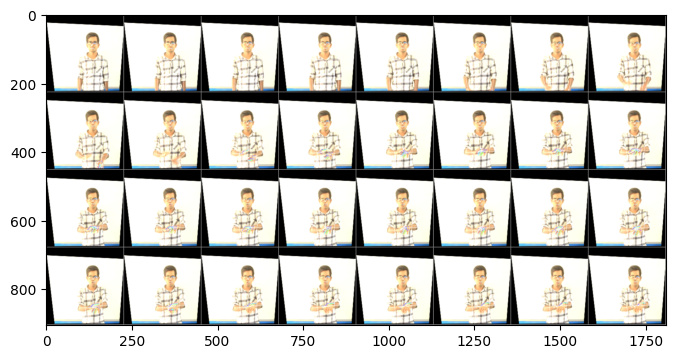

tensor(56)


In [ ]:
inputs = next(iter(train_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)
imgshow(torchvision.utils.make_grid(inputs['pixel_values'].permute(0, 2, 1, 3, 4)[0]))
print(inputs['labels'][0])

torch.Size([16, 3, 32, 224, 224]) torch.Size([16])


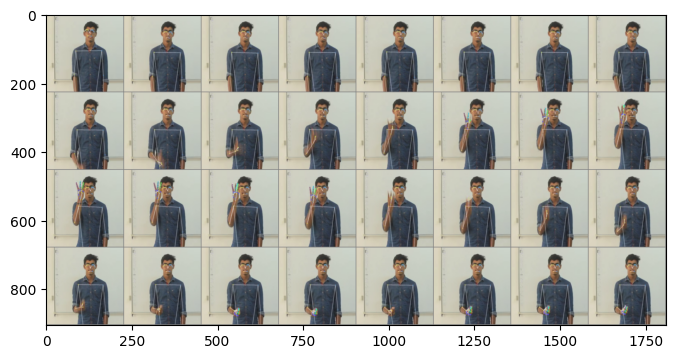

tensor(43)


In [ ]:
inputs = next(iter(val_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)
imgshow(torchvision.utils.make_grid(inputs['pixel_values'].permute(0, 2, 1, 3, 4)[0]))
print(inputs['labels'][0])

torch.Size([16, 3, 32, 224, 224]) torch.Size([16])


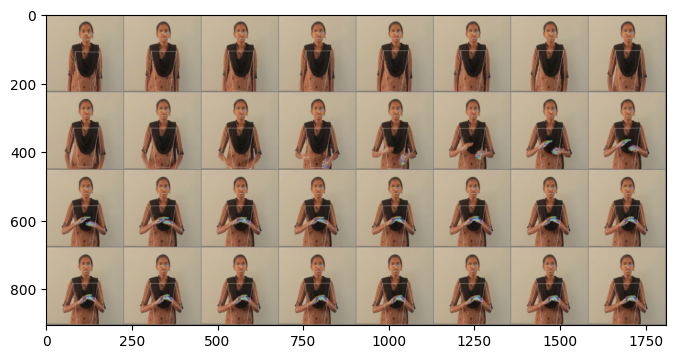

tensor(56)


In [ ]:
inputs = next(iter(test_dl))
print(inputs['pixel_values'].shape, inputs['labels'].shape)
imgshow(torchvision.utils.make_grid(inputs['pixel_values'].permute(0, 2, 1, 3, 4)[0]))
print(inputs['labels'][0])

# NO - Testimg Model Structure - swin_v1

In [ ]:
#sample_model_1 = ptv.swin3d_t(weights=WEIGHTS)

Downloading: "https://download.pytorch.org/models/swin3d_t-7615ae03.pth" to /root/.cache/torch/hub/checkpoints/swin3d_t-7615ae03.pth
100%|██████████| 122M/122M [00:00<00:00, 176MB/s]


In [ ]:
#summary(sample_model_1, (3,32,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 96, 16, 56, 56]           9,312
         LayerNorm-2       [-1, 16, 56, 56, 96]             192
      PatchEmbed3d-3       [-1, 16, 56, 56, 96]               0
           Dropout-4       [-1, 16, 56, 56, 96]               0
         LayerNorm-5       [-1, 16, 56, 56, 96]             192
ShiftedWindowAttention3d-6       [-1, 16, 56, 56, 96]               0
   StochasticDepth-7       [-1, 16, 56, 56, 96]               0
         LayerNorm-8       [-1, 16, 56, 56, 96]             192
            Linear-9      [-1, 16, 56, 56, 384]          37,248
             GELU-10      [-1, 16, 56, 56, 384]               0
          Dropout-11      [-1, 16, 56, 56, 384]               0
           Linear-12       [-1, 16, 56, 56, 96]          36,960
          Dropout-13       [-1, 16, 56, 56, 96]               0
  StochasticDepth-14       [-1, 1

In [ ]:
#sample_model_1

SwinTransformer3d(
  (patch_embed): PatchEmbed3d(
    (proj): Conv3d(3, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (features): Sequential(
    (0): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention3d(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
     

In [ ]:
#sample_model_1.features[6][1]

SwinTransformerBlock(
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): ShiftedWindowAttention3d(
    (qkv): Linear(in_features=768, out_features=2304, bias=True)
    (proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (stochastic_depth): StochasticDepth(p=0.1, mode=row)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): MLP(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.0, inplace=False)
  )
)

In [ ]:
#list(sample_model_1.children())[0]

PatchEmbed3d(
  (proj): Conv3d(3, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
  (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
#list(sample_model_1.children())[1]

Dropout(p=0.0, inplace=False)

In [ ]:
#list(sample_model_1.children())[2]

Sequential(
  (0): Sequential(
    (0): SwinTransformerBlock(
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention3d(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (proj): Linear(in_features=96, out_features=96, bias=True)
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (0): Linear(in_features=96, out_features=384, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=384, out_features=96, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (1): SwinTransformerBlock(
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (attn): ShiftedWindowAttention3d(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (proj): Linear(in_features=96, out_features=96, bias=True)
  

In [ ]:
#list(sample_model_1.children())[3]

LayerNorm((768,), eps=1e-05, elementwise_affine=True)

In [ ]:
#list(sample_model_1.children())[4]

AdaptiveAvgPool3d(output_size=1)

In [ ]:
#list(sample_model_1.children())[5]

Linear(in_features=768, out_features=400, bias=True)

In [ ]:
#sample_model_backbone = list(sample_model_1.children())[:-1]

In [ ]:
#sample_model_1.head

Linear(in_features=768, out_features=400, bias=True)

In [ ]:
#in_features = sample_model_1.head.in_features
#in_features

768

In [ ]:
#sample_model_1.head = torch.nn.Linear(in_features, len(classes))

In [ ]:
## Freeze all layers initially
#for param in sample_model_1.parameters():
#    param.requires_grad = False

In [ ]:
#for param in sample_model_1.head.parameters():
#    param.requires_grad = True

In [ ]:
#summary(sample_model_1, (3, 32, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 96, 16, 56, 56]           9,312
         LayerNorm-2       [-1, 16, 56, 56, 96]             192
      PatchEmbed3d-3       [-1, 16, 56, 56, 96]               0
           Dropout-4       [-1, 16, 56, 56, 96]               0
         LayerNorm-5       [-1, 16, 56, 56, 96]             192
ShiftedWindowAttention3d-6       [-1, 16, 56, 56, 96]               0
   StochasticDepth-7       [-1, 16, 56, 56, 96]               0
         LayerNorm-8       [-1, 16, 56, 56, 96]             192
            Linear-9      [-1, 16, 56, 56, 384]          37,248
             GELU-10      [-1, 16, 56, 56, 384]               0
          Dropout-11      [-1, 16, 56, 56, 384]               0
           Linear-12       [-1, 16, 56, 56, 96]          36,960
          Dropout-13       [-1, 16, 56, 56, 96]               0
  StochasticDepth-14       [-1, 1

# Model Training

In [ ]:
torch.cuda.empty_cache()

In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1000, # set to very high number
    "seed": SEED,
    "patience": 10, # early stopping
    "output_dir_pt": f"{gdrive_path}/Models/swin_tiny_pytorch_GPU_1.pt",
    "attention_dropout": 0.2,
    "dropout_rate": 0.2,
    "num_classes": len(classes),
    #"norm_layer": nn.LayerNorm(normalized_shape=torch.Tensor([3])) # normalized_shape =. number of channels
}

In [ ]:
class SwinTClassifications(nn.Module):
    def __init__(self,classes, weights="DEFAULT"):
        super().__init__()
        self.classes = classes
        self.weights = weights
        # Load pre-trained model
        self.base_model = ptv.swin3d_t(weights=self.weights,
                                       #dropout=hyperparameters['dropout_rate'],
                                       #attention_dropout=hyperparameters['attention_dropout'],
                                       #norm_layer=hyperparameters['norm_layer'],
                                       )

        # Update the Classification layer to have 76 classes
        #self.base_model.head = torch.nn.Linear(self.base_model.head.in_features , len(self.classes))
        self.classification_head = nn.Sequential(torch.nn.Linear(self.base_model.head.in_features , len(self.classes)),
                                             #nn.Softmax(dim=1)
                                             )

        # Remove the classification head
        self.base_model.head = nn.Identity()

        ## Enable gradient checkpointing to save memory
        #self.base_model.gradient_checkpointing_enable()

        # Freeze all layers initially
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Un-Freeze the last Sequential layer
        for param in self.base_model.features[6][1].parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.base_model(x)  # Feature extraction
        x = self.classification_head(x)
        return x  # Return classes

In [ ]:
def training_function():
    # Initialize accelerator with fp16 if available
    accelerator = Accelerator() #mixed_precision="fp16"

    # Instantiate the model and config
    embedding_model = SwinTClassifications(classes=classes, weights=WEIGHTS)
    #embedding_model = ptv.swin3d_t(weights=WEIGHTS,
    #                               dropout=hyperparameters['dropout_rate'],
    #                               num_classes=hyperparameters['num_classes'],
    #                               attention_dropout=hyperparameters['attention_dropout'],
    #                               norm_layer=hyperparameters['norm_layer'])

    # Set seed
    set_seed(hyperparameters["seed"])

    # Loss function
    criterion = torch.nn.CrossEntropyLoss()

    # Filter parameters to include only the ones that require gradients
    trainable_params = [p for p in embedding_model.parameters() if p.requires_grad]
    total_params = sum(p.numel() for p in trainable_params)
    print("trainable parameters:", total_params)

    optimizer = AdamW(embedding_model.parameters(), lr=hyperparameters["learning_rate"])

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=0.00001
    )

    # Prepare objects with the accelerator
    accelerated_model, accelerated_optimizer, accelerated_criterion, accelerated_train_dl, accelerated_val_dl = accelerator.prepare(
        embedding_model, optimizer, criterion, train_dl, val_dl
    )

    accelerator.print(summary(accelerated_model, ((3, 32, 224, 224))))

    # Training loop variables
    epochs_no_improve = 0
    min_val_loss = float("inf")

    for epoch in range(hyperparameters["num_epochs"]):
        progress_bar = tqdm(range(len(accelerated_train_dl)), disable=not accelerator.is_main_process)
        progress_bar.set_description(f"Epoch: {epoch}")
        accelerated_model.train()
        training_loss = []

        for batch in accelerated_train_dl:
            # Extract inputs
            pixel_value = batch['pixel_values']
            label = batch['labels']

            # Forward pass
            outputs = accelerated_model(pixel_value)

            # Compute loss
            train_loss = accelerated_criterion(outputs, label)

            # Backward pass
            accelerator.backward(train_loss)

            # Optimizer step and gradient reset
            accelerated_optimizer.step()
            accelerated_optimizer.zero_grad()

            # Delete unwanted data
            del pixel_value, outputs, label
            gc.collect()

            # Gather loss from all processes
            training_loss.append(accelerator.gather(train_loss[None]))
            progress_bar.set_postfix({'loss': train_loss.detach().item()})
            progress_bar.update(1)

        # Compute average training loss
        training_loss_final = torch.stack(training_loss).sum().item() / len(training_loss)
        accelerator.print(f"epoch {epoch}: learning rate: {scheduler.get_last_lr()}")
        accelerator.print(f"epoch {epoch}: training loss: {training_loss_final}")

        # Evaluation on validation set
        accelerated_model.eval()
        validation_loss = []
        for batch in accelerated_val_dl:
            # Extract inputs
            pixel_value = batch['pixel_values']
            label = batch['labels']

            with torch.no_grad():
                outputs = accelerated_model(pixel_value)

            # Compute loss
            val_loss = accelerated_criterion(outputs, label)
            validation_loss.append(accelerator.gather(val_loss[None]))

            # Delete unwanted data
            del pixel_value, outputs, label
            gc.collect()

        validation_loss_final = torch.stack(validation_loss).sum().item() / len(validation_loss)
        accelerator.print(f"epoch {epoch}: validation loss: {validation_loss_final}")

        # Update the learning rate scheduler
        scheduler.step(validation_loss_final)

        # Early stopping and model saving
        if validation_loss_final < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = validation_loss_final
            # Save the model weights as state_dict
            torch.save(accelerated_model.state_dict(), hyperparameters['output_dir_pt'])
        else:
            epochs_no_improve += 1
            if epochs_no_improve == hyperparameters["patience"]:
                accelerator.print("Early stopping!")
                break

In [ ]:
# Run the trainer function
training_function()

trainable parameters: 7207156
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 96, 16, 56, 56]           9,312
         LayerNorm-2       [-1, 16, 56, 56, 96]             192
      PatchEmbed3d-3       [-1, 16, 56, 56, 96]               0
           Dropout-4       [-1, 16, 56, 56, 96]               0
         LayerNorm-5       [-1, 16, 56, 56, 96]             192
ShiftedWindowAttention3d-6       [-1, 16, 56, 56, 96]               0
   StochasticDepth-7       [-1, 16, 56, 56, 96]               0
         LayerNorm-8       [-1, 16, 56, 56, 96]             192
            Linear-9      [-1, 16, 56, 56, 384]          37,248
             GELU-10      [-1, 16, 56, 56, 384]               0
          Dropout-11      [-1, 16, 56, 56, 384]               0
           Linear-12       [-1, 16, 56, 56, 96]          36,960
          Dropout-13       [-1, 16, 56, 56, 96]               0
  S

  0%|          | 0/47 [00:00<?, ?it/s]

epoch 0: learning rate: [0.0001]
epoch 0: training loss: 4.296474050968252
epoch 0: validation loss: 4.119652557373047


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 1: learning rate: [0.0001]
epoch 1: training loss: 3.9512605058385972
epoch 1: validation loss: 3.581415303548177


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 2: learning rate: [0.0001]
epoch 2: training loss: 3.3477370891165226
epoch 2: validation loss: 2.826483662923177


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 3: learning rate: [0.0001]
epoch 3: training loss: 2.7128453356154423
epoch 3: validation loss: 2.1191041310628256


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 4: learning rate: [0.0001]
epoch 4: training loss: 2.1092115361639796
epoch 4: validation loss: 1.6689806620279948


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 5: learning rate: [0.0001]
epoch 5: training loss: 1.6766214573636968
epoch 5: validation loss: 1.303018569946289


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 6: learning rate: [0.0001]
epoch 6: training loss: 1.4067853562375332
epoch 6: validation loss: 1.1030364990234376


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 7: learning rate: [0.0001]
epoch 7: training loss: 1.2108608813996011
epoch 7: validation loss: 0.8597237904866536


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 8: learning rate: [0.0001]
epoch 8: training loss: 1.1028387191447806
epoch 8: validation loss: 0.8052845001220703


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 9: learning rate: [0.0001]
epoch 9: training loss: 0.9622856302464262
epoch 9: validation loss: 0.6884698232014974


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 10: learning rate: [0.0001]
epoch 10: training loss: 0.9064548573595412
epoch 10: validation loss: 0.638765017191569


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 11: learning rate: [0.0001]
epoch 11: training loss: 0.873186801342254
epoch 11: validation loss: 0.581169319152832


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 12: learning rate: [0.0001]
epoch 12: training loss: 0.7726897381721659
epoch 12: validation loss: 0.5013333320617676


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 13: learning rate: [0.0001]
epoch 13: training loss: 0.7089135190273853
epoch 13: validation loss: 0.5188056945800781


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 14: learning rate: [0.0001]
epoch 14: training loss: 0.7839613569543716
epoch 14: validation loss: 0.4903494199117025


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 15: learning rate: [0.0001]
epoch 15: training loss: 0.6834109691863365
epoch 15: validation loss: 0.49451732635498047


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 16: learning rate: [0.0001]
epoch 16: training loss: 0.6820847531582447
epoch 16: validation loss: 0.44036773045857747


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 17: learning rate: [0.0001]
epoch 17: training loss: 0.5880926822094207
epoch 17: validation loss: 0.4559352238972982


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 18: learning rate: [0.0001]
epoch 18: training loss: 0.6220096831626081
epoch 18: validation loss: 0.4148476918538411


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 19: learning rate: [0.0001]
epoch 19: training loss: 0.6208404378688082
epoch 19: validation loss: 0.4099784215291341


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 20: learning rate: [0.0001]
epoch 20: training loss: 0.5633763252420628
epoch 20: validation loss: 0.39924869537353513


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 21: learning rate: [0.0001]
epoch 21: training loss: 0.5073843611047623
epoch 21: validation loss: 0.4135573069254557


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 22: learning rate: [0.0001]
epoch 22: training loss: 0.5572803984297082
epoch 22: validation loss: 0.37164312998453775


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 23: learning rate: [0.0001]
epoch 23: training loss: 0.5474095445998172
epoch 23: validation loss: 0.4114863713582357


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 24: learning rate: [0.0001]
epoch 24: training loss: 0.5234753628994556
epoch 24: validation loss: 0.36713132858276365


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 25: learning rate: [0.0001]
epoch 25: training loss: 0.4583876589511303
epoch 25: validation loss: 0.36264425913492837


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 26: learning rate: [0.0001]
epoch 26: training loss: 0.45048311923412565
epoch 26: validation loss: 0.36214815775553383


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 27: learning rate: [0.0001]
epoch 27: training loss: 0.5455567786034118
epoch 27: validation loss: 0.39834435780843097


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 28: learning rate: [0.0001]
epoch 28: training loss: 0.3748771180497839
epoch 28: validation loss: 0.40126914978027345


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 29: learning rate: [0.0001]
epoch 29: training loss: 0.45851350337901015
epoch 29: validation loss: 0.3540456453959147


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 30: learning rate: [0.0001]
epoch 30: training loss: 0.3791281111696933
epoch 30: validation loss: 0.4164219856262207


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 31: learning rate: [0.0001]
epoch 31: training loss: 0.4603044631633353
epoch 31: validation loss: 0.39543447494506834


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 32: learning rate: [0.0001]
epoch 32: training loss: 0.3755234251631067
epoch 32: validation loss: 0.39640445709228517


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 33: learning rate: [5e-05]
epoch 33: training loss: 0.3703558089885306
epoch 33: validation loss: 0.3793471018473307


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 34: learning rate: [5e-05]
epoch 34: training loss: 0.40376058537909326
epoch 34: validation loss: 0.3567241668701172


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 35: learning rate: [5e-05]
epoch 35: training loss: 0.4376244240618767
epoch 35: validation loss: 0.3680232048034668


  0%|          | 0/47 [00:00<?, ?it/s]

epoch 36: learning rate: [2.5e-05]
epoch 36: training loss: 0.33577606525826964
epoch 36: validation loss: 0.3525007883707682


  0%|          | 0/47 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Load model

In [ ]:
class SwinTClassifications(nn.Module):
    def __init__(self,classes, weights="DEFAULT"):
        super().__init__()
        self.classes = classes
        self.weights = weights
        # Load pre-trained model
        self.base_model = ptv.swin3d_t(weights=self.weights)

        self.classification_head = nn.Sequential(torch.nn.Linear(self.base_model.head.in_features , len(self.classes)),
                                             #nn.Softmax(dim=1)
                                             )

        # Remove the classification head
        self.base_model.head = nn.Identity()

    def forward(self, x):
        x = self.base_model(x)  # Feature extraction
        x = self.classification_head(x)
        return x  # Return classes

In [ ]:
recon_model = SwinTClassifications(classes=classes, weights=WEIGHTS).to(device)
recon_model.load_state_dict(torch.load(hyperparameters['output_dir_pt'], weights_only=True, map_location=device))
recon_model.eval()
print("Entire model loaded successfully!")
print(summary(recon_model, (3, 32, 224, 224)))

Entire model loaded successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 96, 16, 56, 56]           9,312
         LayerNorm-2       [-1, 16, 56, 56, 96]             192
      PatchEmbed3d-3       [-1, 16, 56, 56, 96]               0
           Dropout-4       [-1, 16, 56, 56, 96]               0
         LayerNorm-5       [-1, 16, 56, 56, 96]             192
ShiftedWindowAttention3d-6       [-1, 16, 56, 56, 96]               0
   StochasticDepth-7       [-1, 16, 56, 56, 96]               0
         LayerNorm-8       [-1, 16, 56, 56, 96]             192
            Linear-9      [-1, 16, 56, 56, 384]          37,248
             GELU-10      [-1, 16, 56, 56, 384]               0
          Dropout-11      [-1, 16, 56, 56, 384]               0
           Linear-12       [-1, 16, 56, 56, 96]          36,960
          Dropout-13       [-1, 16, 56, 56, 96]               0

# Model Testing - TEST Data

In [ ]:
#torch.cuda.empty_cache()

In [ ]:
# Now we train the model
def testing_function(model_pretrained):
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_test_dl = accelerator.prepare(model_pretrained, test_dl)

    # Build the training loop
    epochs_no_improve = 0

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_labels = []
    test_preds = []
    test_outputs = []

    for batch in tqdm(acclerated_test_dl):

        pixel_value = batch['pixel_values']
        test_label = batch['labels']

        with torch.no_grad():
            outputs = accelerated_model(pixel_value)

        test_softmax = torch.nn.functional.softmax(outputs, dim=-1)
        test_pred = test_softmax.argmax(-1)
        test_preds.append(test_pred)

        test_outputs.append(outputs)
        test_labels.append(test_label)


    return test_labels, test_preds, test_outputs


In [ ]:
actual_label, predicted_test_label, predicted_test_outputs = testing_function(recon_model)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
actual_labels = torch.cat(actual_label, 0).to('cpu')
predicted_test_labels = torch.cat(predicted_test_label,0).to('cpu')
predicted_test_outputs = torch.cat(predicted_test_outputs).to('cpu')

In [ ]:
predicted_test_labels.numpy()

array([56, 20, 42,  1, 57,  3, 36, 17, 37, 70, 30, 30, 45, 71, 65, 60, 38,
       71, 29, 40, 26, 59, 53, 52, 74, 48, 58, 75, 74, 69, 64, 47, 58,  2,
       16, 23, 72, 53, 11, 24, 47,  7, 71, 28, 57, 29, 57, 49, 71, 30, 55,
       54, 40, 55, 27, 44,  2, 36,  5, 17, 58,  6, 55,  9, 15, 53, 14, 26,
       14, 74, 15, 58,  0,  1, 29,  2,  7, 47, 73, 75, 39,  7, 24, 42, 28,
       10, 40, 54, 35, 33, 53, 74, 46, 45, 56, 43,  5, 61, 61, 51, 34,  1,
       72, 44, 60, 75, 57, 37, 68, 31, 22, 12, 57, 46,  2, 13,  4, 52, 71,
       52, 22, 42, 52, 14, 31, 11, 20, 27, 35, 21, 50, 66, 49, 61, 52, 26,
       41,  8, 15, 33, 26, 27, 30, 29, 45, 37, 41, 43,  5, 46, 19, 72, 65,
       35, 32,  0, 70, 28, 31, 15, 31, 44, 64, 56, 15, 11, 25, 71, 54,  2,
       67, 61, 42, 69, 38, 18, 44, 35, 68, 20, 73, 25, 41, 39, 68, 33, 59])

In [ ]:
actual_labels

tensor([56, 20, 42,  1, 57,  3, 36, 17, 66, 70, 10, 30, 45, 16, 65, 60, 38, 16,
        29, 40, 26, 59, 53, 52, 62, 48, 51, 75, 74, 69, 64, 47, 58,  2, 16, 23,
        72, 53, 11, 24, 47,  7, 71, 28, 57, 22, 57, 49, 35, 30, 55, 54, 40, 55,
        27, 44,  2, 36,  5, 17, 58,  6, 55,  9,  9, 53, 14, 26, 14, 74, 15, 58,
         0,  1, 29, 25,  7, 47, 73, 75, 39,  7, 24, 42, 28, 10, 40, 54, 35, 33,
        53, 62, 46, 45, 56, 43,  5, 61, 61, 51, 34,  1, 72, 44, 60, 75, 10, 37,
        68, 31, 22, 12, 57, 46,  2, 13,  4, 52, 71, 52, 22, 42, 51, 14, 31, 11,
        20, 27,  4, 21, 50, 66, 49, 61, 60, 28, 41,  8, 15, 33, 26, 27, 30, 29,
        45, 37, 41, 43,  5, 46, 19, 72, 65,  4, 32,  0, 70, 35, 63, 15, 63, 71,
        64, 56,  9, 11, 25, 71, 54,  2, 67, 61, 42, 69, 38, 18, 44,  4, 68, 20,
        73, 25, 41, 39, 68, 33, 59])

In [ ]:
predicted_test_outputs

tensor([[-2.3349, -2.9976,  1.8910,  ..., -0.3498, -4.5878,  6.1791],
        [-2.4832, -4.1901,  7.0058,  ..., -3.7774,  3.6337, -0.9274],
        [ 1.4013, -6.4059,  5.8642,  ..., -1.8560,  1.2424,  2.7293],
        ...,
        [ 5.6165, -4.3840,  2.4771,  ..., -2.1037,  0.6224,  1.4804],
        [-5.8324, -1.5400, -0.7113,  ...,  1.6142, -3.6754,  3.2283],
        [ 3.2898, -2.4104, -1.3684,  ..., -1.0593,  2.1902, -1.0514]])

In [ ]:
predicted_test_outputs.shape

torch.Size([187, 76])

In [ ]:
predicted_test_outputs[0].sum()

tensor(-20.3615)

In [ ]:
predicted_test_outputs[0].argmax()

tensor(56)

In [ ]:
predicted_test_outputs[0][58]

tensor(1.0105)

In [ ]:
print(classification_report(actual_labels.numpy(),
                            predicted_test_labels.numpy(),
                            ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         3
           2       0.80      1.00      0.89         4
           3       1.00      1.00      1.00         1
           4       1.00      0.25      0.40         4
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         1
           9       1.00      0.33      0.50         3
          10       1.00      0.33      0.50         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       0.60      1.00      0.75         3
          16       1.00      0.33      0.50         3
          17       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Testing - Phase 2

In [ ]:
inputs = next(iter(test_dl))
pixel_values = inputs['pixel_values']
labels = inputs['labels']
print(pixel_values.shape, labels.shape)

torch.Size([16, 3, 32, 224, 224]) torch.Size([16])


In [ ]:
# Now we train the model
def testing_function_2(model_pretrained):
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_test_dl = accelerator.prepare(model_pretrained, test_dl)

    # Build the training loop
    epochs_no_improve = 0

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_labels = []
    test_preds = []

    for batch in tqdm(acclerated_test_dl):

        pixel_value = batch['pixel_values']
        test_label = batch['labels']

        with torch.no_grad():
            outputs = accelerated_model(pixel_value)

        #test_softmax = torch.nn.functional.softmax(outputs, dim=-1)
        #test_pred = test_softmax.argmax(-1)
        test_preds.append(outputs)

        test_labels.append(test_label)

    return test_labels, test_preds

In [ ]:
actual_label, predicted_test_output = testing_function(recon_model)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
torch.cat(predicted_test_output)

tensor([56, 35, 10, 71, 73, 11, 51, 51, 71, 56, 56, 30, 56, 26, 30, 51, 30, 26,
        56, 28, 53, 35, 73,  5, 30, 71, 53, 51, 56, 71,  0, 51, 35, 30, 51, 71,
        73, 56, 56, 73, 40, 29, 46, 73, 30, 73, 60, 28, 56, 71, 26, 56, 51, 71,
        35, 10, 52, 71, 28, 73, 53, 30, 71, 73, 73, 10, 30, 51, 44, 25, 56, 51,
        25, 71, 56, 68, 11,  2, 56, 73, 71, 30, 73, 28, 10, 53, 51, 71, 10, 61,
        26, 51, 30, 56, 60, 73, 30, 73, 46, 73, 51, 71, 30, 30, 16, 53, 73, 56,
        51, 56, 73, 53, 10, 73, 30, 10, 10, 53, 53, 73, 56, 26, 73, 51, 46, 10,
        53, 10, 73, 30, 52, 56, 73, 73,  5, 35, 56, 33,  2, 30, 71, 71, 29, 56,
        56, 46, 56, 33, 73, 28, 73, 26, 73, 26, 33, 46, 71, 14, 73, 16,  1, 73,
        71, 26, 73, 71, 25, 29, 60, 53, 41, 53, 73, 71, 56, 73, 73, 26, 56, 52,
        56, 51, 73, 52, 73, 71, 39], device='cuda:0')

In [ ]:
predicted_test_output

[tensor([56, 35, 10, 71, 73, 11, 51, 51, 71, 56, 56, 30, 56, 26, 30, 51],
        device='cuda:0'),
 tensor([30, 26, 56, 28, 53, 35, 73,  5, 30, 71, 53, 51, 56, 71,  0, 51],
        device='cuda:0'),
 tensor([35, 30, 51, 71, 73, 56, 56, 73, 40, 29, 46, 73, 30, 73, 60, 28],
        device='cuda:0'),
 tensor([56, 71, 26, 56, 51, 71, 35, 10, 52, 71, 28, 73, 53, 30, 71, 73],
        device='cuda:0'),
 tensor([73, 10, 30, 51, 44, 25, 56, 51, 25, 71, 56, 68, 11,  2, 56, 73],
        device='cuda:0'),
 tensor([71, 30, 73, 28, 10, 53, 51, 71, 10, 61, 26, 51, 30, 56, 60, 73],
        device='cuda:0'),
 tensor([30, 73, 46, 73, 51, 71, 30, 30, 16, 53, 73, 56, 51, 56, 73, 53],
        device='cuda:0'),
 tensor([10, 73, 30, 10, 10, 53, 53, 73, 56, 26, 73, 51, 46, 10, 53, 10],
        device='cuda:0'),
 tensor([73, 30, 52, 56, 73, 73,  5, 35, 56, 33,  2, 30, 71, 71, 29, 56],
        device='cuda:0'),
 tensor([56, 46, 56, 33, 73, 28, 73, 26, 73, 26, 33, 46, 71, 14, 73, 16],
        device='cuda:0'),


# Create MP Objects

In [ ]:
hand_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/hand_landmarker.task'
pose_model_path = '/content/drive/MyDrive/Kaggle/SignLanguage/pose_landmarker.task'

In [ ]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
#FaceLandmarker = mp.tasks.vision.FaceLandmarker
#FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a hand landmarker instance with the video mode:
options_hand = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path = hand_model_path),
    running_mode=VisionRunningMode.VIDEO)

# Create a pose landmarker instance with the video mode:
options_pose = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=pose_model_path),
    running_mode=VisionRunningMode.VIDEO)

## Create a face landmarker instance with the video mode:
#options_face = FaceLandmarkerOptions(
#    base_options=BaseOptions(model_asset_path=face_model_path),
#    running_mode=VisionRunningMode.VIDEO)

#detector_face = vision.FaceLandmarker.create_from_options(options_face)
detector_hand = vision.HandLandmarker.create_from_options(options_hand)
detector_pose = vision.PoseLandmarker.create_from_options(options_pose)

In [ ]:
holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    enable_segmentation=False,
    refine_face_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
    )

# Model testing - PROD Data

In [ ]:
class CustomDatasetProd(Dataset):
    def __init__(self, pixel_values):
        self.pixel_values = pixel_values.to('cpu')

    def __len__(self):
        return len(self.pixel_values)

    def __getitem__(self, idx):
        item = {
            'pixel_values': self.pixel_values[idx]
        }
        return item

In [ ]:
class CreateDatasetProd():
    def __init__(self
                , clip_len
                , clip_size
                , frame_step
                ):
        super().__init__()
        self.clip_len = clip_len
        self.clip_size = clip_size
        self.frame_step = frame_step

        # Define a sample transformation pipeline
        self.transform_prod = transforms.v2.Compose([
                                    transforms.v2.ToImage(),
                                    transforms.v2.Resize((self.clip_size, self.clip_size)),
                                    transforms.v2.ToDtype(torch.float32, scale=True)
                                ])

    def read_video(self, video_path):
        # Read the video and convert to frames
        vr = VideoReader(video_path)
        total_frames = len(vr)

        # Determine frame indices based on total frames
        if total_frames < self.clip_len:
            key_indices = list(range(total_frames))
            for _ in range(self.clip_len - len(key_indices)):
                key_indices.append(key_indices[-1])
        else:
            key_indices = list(range(0, total_frames, max(1, total_frames // self.clip_len)))[:self.clip_len]

        #load frames
        frames = vr.get_batch(key_indices)
        del vr
        # Force garbage collection
        gc.collect()

        return frames

    def add_landmarks(self, video):
        annotated_image = []
        for frame in video:

            #Convert pytorch Tensor to CV2 image
            image = frame.permute(1, 2, 0).numpy() # Convert to (H, W, C) format for mediapipe to work

            results = holistic.process(image)

            mp_drawing.draw_landmarks(
                image,
                results.left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec = mp_drawing_styles.get_default_hand_connections_style()
                )
            mp_drawing.draw_landmarks(
                image,
                results.pose_landmarks,
                mp_holistic.POSE_CONNECTIONS,
                landmark_drawing_spec = mp_drawing_styles.get_default_pose_landmarks_style(),
                #connection_drawing_spec = None
                )

            annotated_image.append(torch.from_numpy(image))

            del image, results
            # Force garbage collection
            gc.collect()

        return torch.stack(annotated_image)

    def create_dataset(self, video_paths):
        pixel_values = []
        for path in tqdm(video_paths):
            #print('Video', path)
            # Read and process Videos
            video = self.read_video(path)
            #print('Stage 1',video.shape)
            video = transforms.v2.functional.resize(video.permute(0, 3, 1, 2), size=(self.clip_size*2, self.clip_size*3)) # Auto converts to (F, C, H, W) format
            #print('Stage 2',video.shape)
            video = self.add_landmarks(video)
            #print('Stage 3',video.shape)
            # Data Preperation for ML Model without Augmentation
            video = self.transform_prod(video.permute(0, 3, 1, 2))

            #print('Stage 4',video.shape)
            pixel_values.append(video.to(device))
            del video
            # Force garbage collection
            gc.collect()

        pixel_values = torch.stack(pixel_values).to(device)
        return CustomDatasetProd(pixel_values=pixel_values)


In [ ]:
dataset_prod_obj = CreateDatasetProd(CLIP_LENGTH, CLIP_SIZE, FRAME_STEPS)

In [ ]:
prod_data_dir = f'{gdrive_path}/ProdData'
print(prod_data_dir)

/content/drive/MyDrive/Kaggle/SignLanguage/ProdData


In [ ]:
# Collect all video files
prod_video_path = []

prod_video_file = glob(os.path.join(prod_data_dir, '*.mov'))
print(prod_video_file)
prod_video_path.extend(prod_video_file)

['/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_2_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_3_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_1_ugly.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_4_short.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_5_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_6_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_7_quiet.mov']


In [ ]:
print('input path size:', len(prod_video_path))
print(prod_video_path)

input path size: 7
['/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_2_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_3_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_1_ugly.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_4_short.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_5_tall.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_6_sad.mov', '/content/drive/MyDrive/Kaggle/SignLanguage/ProdData/prod_7_quiet.mov']


In [ ]:
prod_ds = dataset_prod_obj.create_dataset(prod_video_path)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
prod_dl = DataLoader(prod_ds, batch_size=BATCH_SIZE)

In [ ]:
prod_inputs = next(iter(prod_dl))
print(prod_inputs['pixel_values'].shape) #prod_inputs['input_ids'].shape, prod_inputs['attention_mask'].shape, np.array(prod_inputs['labels']).shape

torch.Size([4, 32, 3, 224, 224])


In [ ]:
sample_video = prod_inputs['pixel_values'][0].permute(0, 2, 3, 1)
sample_video.shape

torch.Size([32, 224, 224, 3])

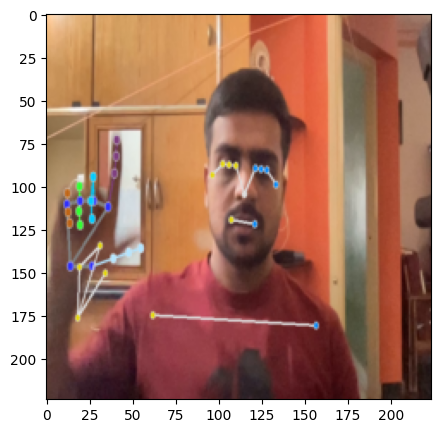

In [ ]:
plt.imshow(sample_video[15])

In [ ]:
# Now we train the model
def prod_function():
    # Initialize accelerator
    accelerator = Accelerator()#(fp16=True)

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Load the model
    model_pretrained = VivitForVideoClassification.from_pretrained(hyperparameters['output_dir_transformer'])

    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    accelerated_model, acclerated_prod_dl = accelerator.prepare(model_pretrained, prod_dl)

    # Build the training loop
    epochs_no_improve = 0

    # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    accelerated_model.eval()

    test_preds = []

    for batch in tqdm(acclerated_prod_dl):
        with torch.no_grad():
            outputs = accelerated_model(**batch)

        test_logits = outputs.logits
        test_softmax = torch.nn.functional.softmax(test_logits, dim=-1)
        test_pred = test_softmax.argmax(-1)
        test_preds.append(test_pred)

        #test_preds = torch.cat(test_pred)
        #test_labels = torch.cat(test_label)
    return test_preds


In [ ]:
predicted_label = prod_function()

loading configuration file /content/drive/MyDrive/Kaggle/SignLanguage/vivit_pytorch_transformer_GPU_4/config.json
Model config VivitConfig {
  "_name_or_path": "google/vivit-b-16x2",
  "architectures": [
    "VivitForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu_fast",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "bad",
    "1": "beautiful",
    "2": "big",
    "3": "blind",
    "4": "cheap",
    "5": "cold",
    "6": "curved",
    "7": "deaf",
    "8": "dry",
    "9": "famous",
    "10": "fast",
    "11": "female",
    "12": "flat",
    "13": "good",
    "14": "happy",
    "15": "healthy",
    "16": "hot",
    "17": "light",
    "18": "long",
    "19": "loose",
    "20": "loud",
    "21": "narrow",
    "22": "new",
    "23": "old",
    "24": "quiet",
    "25": "sad",
    "26": "short",
    "27": "sick",
    "28": "slow",
    "29": "small",
    "30": "tall",
    "31": "warm",
    "32": "wet",
    "33": "wide",
   

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
predicted_label

[tensor([32,  8, 22, 26], device='cuda:0'),
 tensor([30, 18, 24], device='cuda:0')]

In [ ]:
predicted_prod_labels = torch.cat(predicted_label,0).to('cpu')

In [ ]:
for val in predicted_prod_labels:
  print(idx_to_label[val.item()])

wet
dry
new
short
tall
long
quiet


In [ ]:
for path in prod_video_path:
  print(os.path.basename(path).split('/')[-1])

prod_2_tall.mov
prod_3_sad.mov
prod_1_ugly.mov
prod_4_short.mov
prod_5_tall.mov
prod_6_sad.mov
prod_7_quiet.mov


In [ ]:
idx_to_label

{0: 'bad',
 1: 'beautiful',
 2: 'big',
 3: 'blind',
 4: 'cheap',
 5: 'cold',
 6: 'curved',
 7: 'deaf',
 8: 'dry',
 9: 'famous',
 10: 'fast',
 11: 'female',
 12: 'flat',
 13: 'good',
 14: 'happy',
 15: 'healthy',
 16: 'hot',
 17: 'light',
 18: 'long',
 19: 'loose',
 20: 'loud',
 21: 'narrow',
 22: 'new',
 23: 'old',
 24: 'quiet',
 25: 'sad',
 26: 'short',
 27: 'sick',
 28: 'slow',
 29: 'small',
 30: 'tall',
 31: 'warm',
 32: 'wet',
 33: 'wide',
 34: 'young'}

In [ ]:
#print(classification_report(test_label,predicted_label))